## 5.2 Проанализировать результаты эксперимента, который провели вместе с командой дата сайентистов.
* Эксперимент проходил с 2022-10-03 по 2022-10-09 включительно. <br>
* Для эксперимента были задействованы 2 и 1 группы. <br>   

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.<br>
##### Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.<br> 

### Задача — проанализировать данные АB-теста.
1. Провести анализ всеми разобраннымив уроке тестами и сравнить CTR в двух группах:<br>
* t-тест, <br>
* Пуассоновский бутстреп, <br>
* тест Манна-Уитни, <br>
* t-тест на сглаженном ctr (α=5) <br>
* t-тест и тест Манна-Уитни поверх бакетного преобразования.<br>
2. Посмотреть на распределения глазами. <br>
4. Ответить на вопрос: Почему тесты сработали так как сработали? <br>
5. Опишите потенциальную ситуацию, когда такое изменение могло произойти.<br>
Тут нет идеального ответа, подумайте.<br>
6. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [1]:
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats

#для расчета доверительного интервала sms.DescrStatsW(df_group[column]).tconfint_mean()
import statsmodels.stats.api as sms 
import matplotlib.pyplot as plt
from scipy.stats import t

import warnings # игнорирую предупреждения системы об грядущих изменениях
warnings.simplefilter('ignore')

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20221020',
              'user':'student', 
              'password':'dpo_python_2020'
             }

In [3]:
# выгружаю данные
q = '''
    SELECT exp_group,
           user_id, 
           sum(action = 'like') as likes,
           sum(action = 'view') as views,
           (likes / views) as ctr      
    FROM {db}.feed_actions
    WHERE toDate(time) BETWEEN '2022-10-03' and '2022-10-09'
    AND exp_group in (1, 2)
    GROUP BY  exp_group, user_id
    '''
df_ab = ph.read_clickhouse(q, connection = connection)

In [4]:
df_ab.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [5]:
# проверяем размеры групп - размеры групп примерно одинаковые
df_ab.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


In [6]:
# проверяю, чтобы один и тот же id не попал в разные группы 

print('Всего пользователей в 2 группах группах: ', df_ab.user_id.count())
print()
df_ab.uniq = df_ab.groupby('user_id')['exp_group'].nunique().reset_index()
df_ab.uniq.groupby('exp_group').user_id.count()

# каждый id попал только в 1 группу

Всего пользователей в 2 группах группах:  20031



exp_group
1    20031
Name: user_id, dtype: int64

<AxesSubplot:xlabel='ctr', ylabel='Count'>

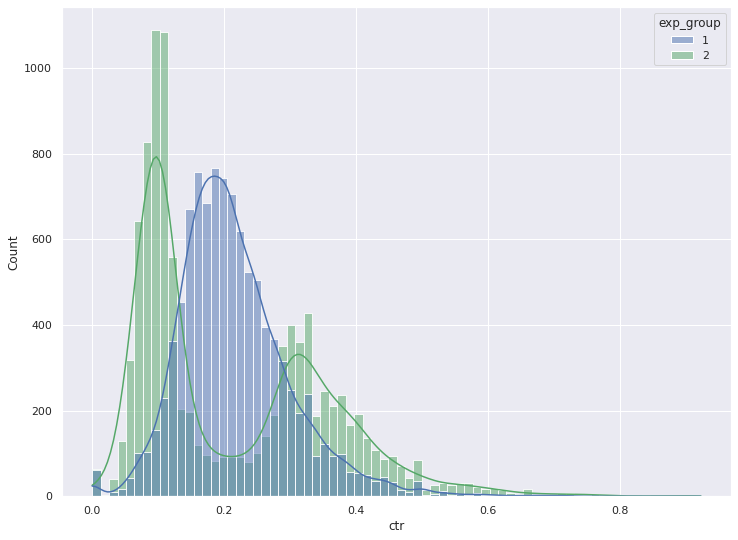

In [7]:
#строю график рааспределения CTR
sns.set(rc={'figure.figsize': (12, 9)})

sns.histplot(data = df_ab,
            x = 'ctr',
            hue = 'exp_group',
            palette = ['b', 'g'],
            alpha = 0.5,
            kde = True)

# распределение CTR в группе 2 имеет два горба !!!
# распределение CTR в группе 1 имеет 1 пик и стремится к нормальному распределению

#### Среднее, мода, медиана
Среднее, мода и медиана в контрольной группе (№ 1) почти одинаковые  - отличия незначительные. <br>
При этом в тестовой группе (№ 2) отличия между средним, модой и медианой значительные. <br><br>
Средние значения в двух выборках отличаются незначительно. <br>
А вот медиана и мода очень различаются:
* при этом мода тестовой группы больше, чем мода контрольной группы, 
* а медиана тестовой группы меньше, чем медиана контрольной группы. <br>

Это вызвано тем, что распределение ctr в тестовой группе имеет два горба (двумодальное), а в контрольной очень похоже на нормальное. <br>

In [8]:
#смотрю среднее, моду, медиану в группaх
df_ab.groupby('exp_group', as_index = False).agg({'ctr': ['mean', pd.Series.mode, 'median']})

exp_group       ctr                    
                 mean      mode    median
0         1  0.215605  0.200000  0.203125
1         2  0.214419  0.333333  0.142857

### 5.2.1 Сравниваю CTR в двух группах

Проверяю 2 гипотезы: <br><br>
Нулевая гипотеза Н0: М1 = М2 <br>
Средние значения равны, значит различий между двумя выборками нет. <br><br>
Альтернативная гипотеза Н1: М1 != М2 (pvalue < 0.05)<br>
Средние значения НЕ равны. <br>

## t-тест

In [9]:
# ВАРИАНТ 1 в clickhouse
# t-test clickhouse
q = '''
WITH welchTTest(ctr, exp_index) as ttest
select tupleElement(ttest, 1) as statistic, tupleElement(ttest, 2) as p_value
FROM (
    SELECT exp_group, user_id, 
    CASE WHEN exp_group = 2 THEN 0 ELSE 1 END as exp_index,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    (likes / views) as ctr
    FROM {db}.feed_actions
    WHERE toDate(time) BETWEEN '2022-10-03' and '2022-10-09'
          AND exp_group IN (1, 2)
    GROUP BY exp_group, user_id
    )
'''
df_clickhouse_ttest = ph.read_clickhouse(q, connection = connection)
df_clickhouse_ttest

,statistic,p_value
0,-0.709439,0.478062


In [10]:
# ВАРИАНТ 2 в Python
# t-test
# считаю pvalue на двугорбом распределении выборки 2
stats.ttest_ind( df_ab[df_ab.exp_group == 2].ctr,
                df_ab[df_ab.exp_group == 1].ctr, 
                equal_var = False)

Ttest_indResult(statistic=-0.7094392041270486, pvalue=0.4780623130874935)

#### Вывод по результатам  t-test
По результатам  t-test получили pvalue=0.478062.<br> 
При  pvalue > 0.05 нужно сделать вывод, что у нас не достаточно оснований, чтобы отклонить нулевую гипотезу, из которой следует, что средние CTR двух выборок равны.<br> 
Ранее мною были рассчитаны средние значения тестовой и контрольной групп, которые практически равны и t-test это подтвердил: <br> 
среднее значение 1 группы = 0.215605	<br> 
среднее значение 2 группы =	0.214419

### тест Манна-Уитни
Нулевая гипотеза Н0: Р(X > Y) = P(Y > X)<br>
Альтернативная гипотеза Н1: Р(X > Y) != P(Y > X) (pvalue < 0.05)

In [11]:
# ВАРИАНТ 1 в clickhouse
# Манн Уитни clickhouse

q  = '''
WITH mannWhitneyUTest('two-sided')(ctr, exp_index) as mw
SELECT tupleElement(mw, 1) as statistic, tupleElement(mw, 2) as p_value
FROM (
    SELECT exp_group, user_id,
    CASE WHEN exp_group = 2 THEN 0 ELSE 1 END as exp_index,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    (likes / views) as ctr 
    FROM {db}.feed_actions
    WHERE toDate(time) BETWEEN '2022-10-03' and '2022-10-09'
          AND exp_group IN (1, 2)
    GROUP BY user_id, exp_group
    )
    '''
df_clickhouse_mw = ph.read_clickhouse(q, connection = connection)
df_clickhouse_mw

,statistic,p_value
0,43707009.5,1.769696e-13


In [12]:
# ВАРИАНТ 2 в Python
# Манн Уитни

A_gt_B = 0
for _ in range(10000):
    A_gt_B += df_ab[df_ab.exp_group == 2].ctr.sample().values[0] > df_ab[df_ab.exp_group == 1].ctr.sample().values[0]
print('В ', A_gt_B / 100, '% случаев A > B. Должно получиться около 50%')

print()

print(stats.mannwhitneyu(df_ab[df_ab.exp_group == 2].ctr,
                  df_ab[df_ab.exp_group == 1].ctr) )

В  43.24 % случаев A > B. Должно получиться около 50%

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)


#### Вывод по результатам теста Манна Уитни
В результате проведеннного теста Манна Уитни получила pvalue < 0.05, следовательно должны принять альтернативную гипотезу, которая говорит, о том, что средний ctr контрольной и тестовой групп не равны. <br> 
pvaluе < 0.05 говорит о том, что мы получили статистические значимые различия на уровне значимости α. 

### Пуассоновский бутстреп для подсчета разницы в CTR

In [13]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


In [14]:
likes1 = df_ab[df_ab.exp_group == 1].likes.to_numpy()
views1 = df_ab[df_ab.exp_group == 1].views.to_numpy()
likes2 = df_ab[df_ab.exp_group == 2].likes.to_numpy()
views2 = df_ab[df_ab.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

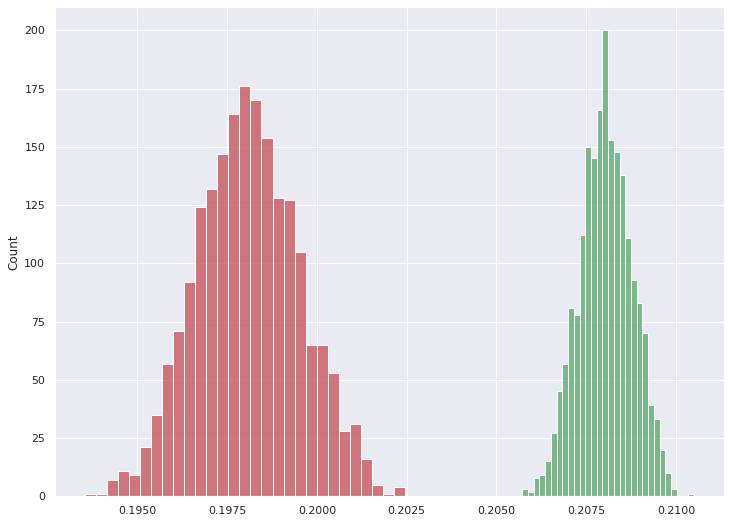

In [15]:
sns.histplot(ctr1, color = ['g']) # зеленым - ctr группы 1
sns.histplot(ctr2, color = ['r']) # красным - ctr группы 2
# глобальный CTR контрольной группы больше чем глобальный  CTR тестовой 
# и на графике глобальный CTR контрольной группы (зеленый) находится справа от глобального CTR тестовой группы (красный)
# т.е. глобальный CTR контрольной группы больше глобального CTR тестовой группы

<AxesSubplot:ylabel='Count'>

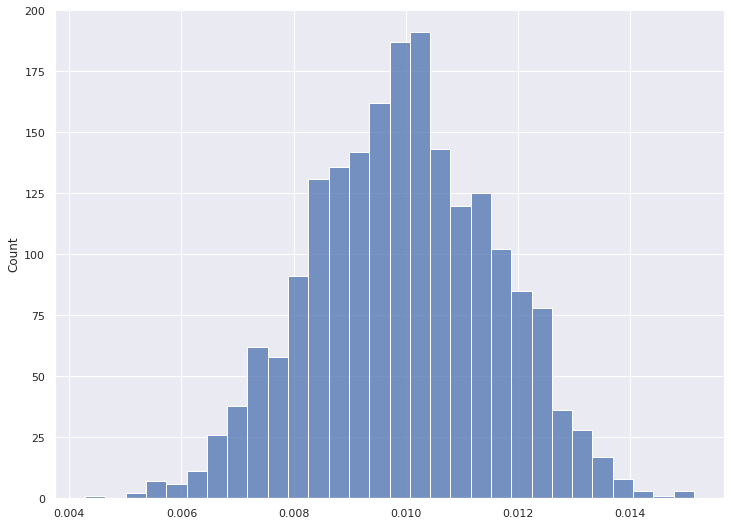

In [16]:
# разница между глобальными CTR
sns.histplot(ctr1 - ctr2)
# глобальный CTR контрольной группы - глобальный CTR тестовой группы 
# разница между глобальными CTR положительная, значиит глобальный CTR контрольной группы больше, 
# чем глобальный CTR тестовой

#### Вывод по результатам Пуассоновского бутстрепа для подсчета разницы в CTR
Глобальный CTR контрольной группы больше, чем глобальный CTR тестовой группы. <br>
Следовательно должны принять альтернативную гипотезу, которая говорит, о том, что средний ctr контрольной и тестовой групп не равны

### t-тест на сглаженном ctr (α=5)

In [17]:
# функция для подсчета сглаженнного CTR 
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [18]:
# считаю глобальный ctr для групп 1 и 2 
global_ctr_1 = df_ab[df_ab.exp_group == 1].likes.sum() / df_ab[df_ab.exp_group == 1].views.sum()
global_ctr_2 = df_ab[df_ab.exp_group == 2].likes.sum() / df_ab[df_ab.exp_group == 2].views.sum()

In [19]:
group1 = df_ab[df_ab.exp_group == 1].copy()  # датафрейм для графика ctr для контрольной группы № 1
group2 = df_ab[df_ab.exp_group == 2].copy() # датафрейм для графика ctr для контрольной группы № 2

In [20]:
# считаю сглаженный ctr
group1['smothed_ctr'] = df_ab.apply(
                        lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group2['smothed_ctr'] = df_ab.apply(
                        lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

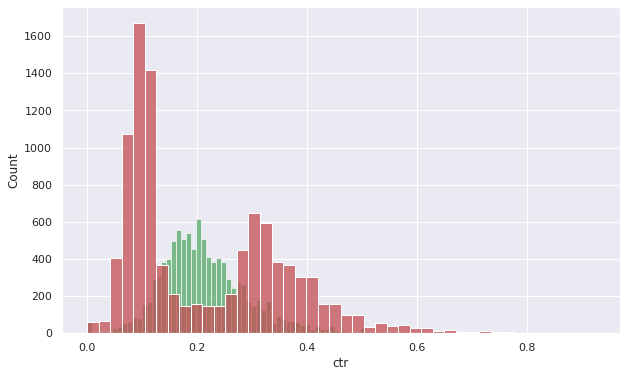

In [21]:
# строю графики ctr для контрольной группы № 1 - зеленый, для тестовой №2 - красный 
sns.set(rc={'figure.figsize': (10, 6)})
sns.histplot(group1.ctr, color = ['g']) # ctr для контрольной группы № 1
sns.histplot(group2.ctr, color = ['r']) # ctr для контрольной группы № 2

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

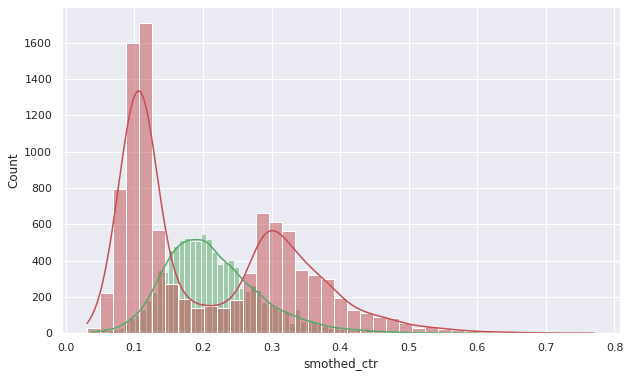

In [22]:
# строю графики сглаженного ctr для контрольной группы № 1 - зеленый, для тестовой №2 - красный 
sns.set(rc={'figure.figsize': (10, 6)})
sns.histplot(group1.smothed_ctr, color = ['g'], kde = True) # ctr для контрольной группы № 1
sns.histplot(group2.smothed_ctr, color = ['r'], kde = True) # ctr для контрольной группы № 2        

График распределения сглаженного CTR немного сгладился.<br>
Однако в целом графики распределения обычного CTR и сглаженного CTR похожи.<br>
Распределение CTR тестовой группы имеет два горба. <br>
Распределение CTR контрольной группы похоже на нормальное распределение.<br>

In [23]:
stats.ttest_ind(group1[group1.exp_group == 1].smothed_ctr, 
                group2[group2.exp_group == 2].smothed_ctr, 
                equal_var = False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

#### Вывод по результатам t-тест на сглаженном ctr (α=5)
В результате проведеннного t-теста  на сглаженном ctr (α=5) получила pvalue=0.0223769815558559.<br>
При pvaluе < 0.05 мы должны принять альтернативную гипотезу, которая говорит, о том, что средний сглаженный ctr контрольной и тестовой не равны. <br> 
pvaluе < 0.05 говорит о том, что мы получили статистические значимые различия на уровне значимости α.

### t-тест и тест Манна-Уитни поверх бакетного преобразования

In [24]:
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) BETWEEN '2022-10-03' and '2022-10-09'
          AND exp_group IN (1, 2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_ab_bucket = ph.read_clickhouse(q, connection=connection)

In [25]:
# тест Манна-Уитни видит отличие
stats.mannwhitneyu(df_ab_bucket[df_ab_bucket.exp_group == 1].bucket_ctr, 
                   df_ab_bucket[df_ab_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [26]:
#t-тест тоже видит отличие - pvalue < 0.05
stats.ttest_ind(df_ab_bucket[df_ab_bucket.exp_group == 1].bucket_ctr, 
                   df_ab_bucket[df_ab_bucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

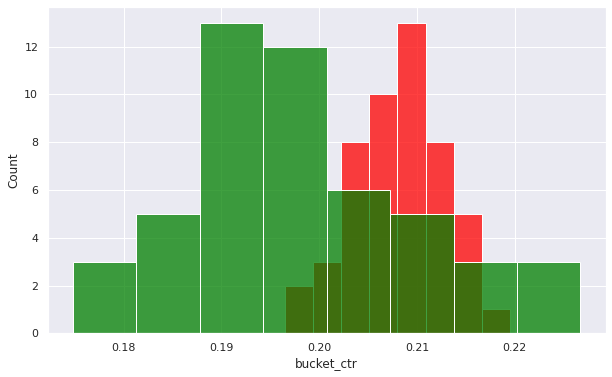

In [27]:
sns.histplot(df_ab_bucket[df_ab_bucket.exp_group == 1].bucket_ctr, color = 'red') # bucket_ctr контрольной группы № 1
sns.histplot(df_ab_bucket[df_ab_bucket.exp_group == 2].bucket_ctr, color = 'green') # bucket_ctr тестовой группы № 2
# на графике видно, что bucket_ctr контрольной группы пересекается с bucket_ctr тестовой группы, 
# но при этом находится в правом хвосте, т.е. средний bucket_ctr контрольной группы больше 
# также стоит заметить,что распределение bucket_ctr похоже на нормальное распределение

In [28]:
#рассчитываю среднее значение и медиану bucket_ctr
# среднее и медиану bucket_ctr контрольной группы больше
df_ab_bucket.groupby('exp_group', as_index = False).agg({'bucket_ctr': ['mean', 'median']})

exp_group bucket_ctr          
                  mean    median
0         1   0.208122  0.208704
1         2   0.198259  0.196209

#### Вывод по результатам t-теста и теста Манна-Уитни поверх бакетного преобразования
В результате проведеннных t-теста и теста Манна-Уитни поверх бакетного преобразования получила pvalue < 0.05, т.е. получила статистические значимые отклонение. <br>
При таком pvalue должна сделать вывод, что средние значения CTR двух выборок различаются и есть все основания принять альтернативную гипотезу.<br>

## Вывод по результатам задания 5.2.2

Из-за того, что распределение CTR в тестовой группе имеет два горба, тесты, которые были применены для анализа результатов AB-теста, дали разные результаты. <br>
* В классическом t-test мы получили pvalue > 0.05 поэтому у нас нет оснований отклонить нулевую гипотезу о равенстве средних значений двух выборок. <br>
* По результатам остальных тестов получили pvalue < 0.05, что говорит о том, что мы получили статистически значимые различия, и нужно принять альтернативную гипотезу о том, что средние двух выборок не равны. <br>
 <br> 
 
Чтобы принять решение, раскатывать новый алгоритм на всех пользователей, посмотрим на меры центральной тенденции двух выборок.<br> 
Из-за того, что распределение признака (CTR) в тестовой группе имеет два горба, среднее значение и медиана в тестовой группе значительно отличается. При этом отличий между модой/медианой/средним в контрольной группе почти нет.<br>
Поэтому считаю, что для интерпретации результатов тестов вместо среднего значения лучше использовать значение медианы.  Поскольку значение медианого ctr контрольной группы больше медианого сtr тестовой группы, 
##### моя рекомендация НЕ раскатывать новый алгоритм на всех новых пользователей.


### Доверительный интервал в качестве альтернативы проверки гипотез   
Если предполагаемая медиана тестовой выборки не будет принадлежать 95% доверительному интервалу рассчитанному по выборочным данным контрольной выборки, то у нас будет достаточно оснований отклонить H0

                       Mx       SD         M        N        SE  interval  \
Выборка_control  0.215605  0.08416  0.203125  10079.0  0.000838  0.001643   
Выборка_test     0.214419  0.14418  0.142857   9952.0  0.001445  0.002833   

                 interval_median     int_1     int_2  median_int_1  \
Выборка_control         0.001643  0.213961  0.217248      0.201482   
Выборка_test            0.002833  0.211586  0.217252      0.140024   

                 median_int_2  
Выборка_control      0.204768  
Выборка_test         0.145690  


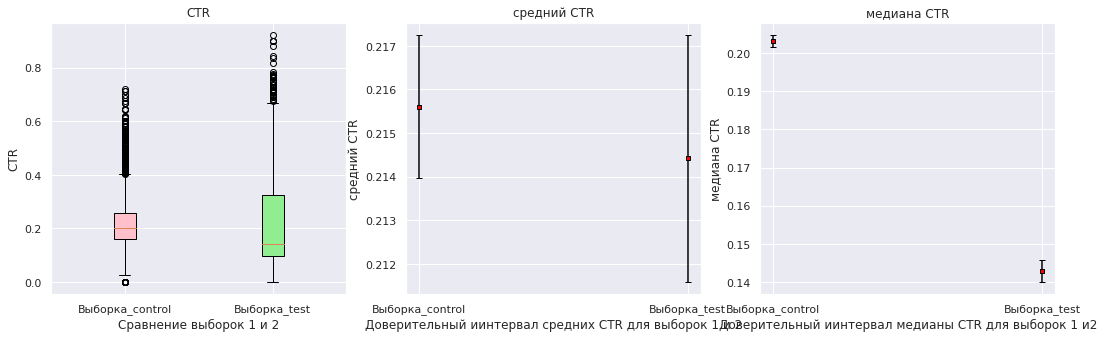

In [29]:
array1 = df_ab[df_ab.exp_group == 1].ctr
array2 = df_ab[df_ab.exp_group == 2].ctr

# считаем количество элементов, среднее, стандартное отклонение и стандартную ошибку
df = pd.DataFrame({'Выборка_control':array1, 'Выборка_test':array2}).agg(['mean','std','median', 'count','sem']).transpose()
df.columns = ['Mx','SD', 'M' ,'N','SE']

# рассчитываем 95% интервал отклонения среднего
p = 0.95
K = t.ppf((1 + p)/2, df['N']-1) 
#K - половина интервала (в относительных единицах по отношению к СКО), в котором содержится p (в данном случае 95%) 
#всех значений для распределения Стьюдента с соответствующей степенью свободы.
df['interval'] = K * df['SE'] 
df['interval_median'] = K * df['SE'] 

#добавляет ещё один столбец (собственно доверит. интервалы уже в абсолютных единицах) в исходный датафрейм df.
df['int_1'] =  df['Mx'] - df['interval'] 
df['int_2'] =  df['Mx'] + df['interval']

#добавляет ещё один столбец (собственно доверит. интервалы уже в абсолютных единицах) для МЕДИАНЫ в исходный датафрейм df.
df['median_int_1'] =  df['M'] - df['interval_median'] 
df['median_int_2'] =  df['M'] + df['interval_median'] 

#строим графики, boxplot из изначальных данных array1, array2,  доверительные интервалы из датафрейма df
fig, (ax1, ax2, ax3 ) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# график boxplot
bplot1 = ax1.boxplot([array1, array2],
                     vert=True,  # создаем вертикальные боксы
                     patch_artist=True, # для красоты заполним цветом боксы квантилей
                     labels=['Выборка_control', 'Выборка_test']) 
                    # используется для задания значений выборок в случае с boxplot

# график доверительных интервалов для СРЕДНИХ
bplot2 = ax2.errorbar(x=df.index, y=df['Mx'], yerr=df['interval'],\
                      color="black", capsize=3, marker="s", markersize=4, mfc="red", mec="black", fmt ='o')

# график доверительных интервалов для МЕДИАН
bplot3 = ax3.errorbar(x=df.index, y=df['M'], yerr=df['interval_median'],\
                      color="black", capsize=3, marker="s", markersize=4, mfc="red", mec="black", fmt ='o')

# раскрасим boxplot  
colors = ['pink', 'lightgreen']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)


ax1.yaxis.grid(True)
ax1.set_title(''+ 'СTR')
ax1.set_xlabel('Сравнение выборок 1 и 2')
ax1.set_ylabel(''+ 'CTR')    
    
    
ax2.yaxis.grid(True)
ax2.set_title(''+ 'средний СTR')
ax2.set_xlabel('Доверительный иинтервал средних СTR для выборок 1 и 2')
ax2.set_ylabel(''+ 'средний CTR')    

ax3.yaxis.grid(True)
ax3.set_title(''+ 'медиана СTR')
ax3.set_xlabel('Доверительный иинтервал медианы СTR для выборок 1 и2')
ax3.set_ylabel(''+ 'медиана CTR')
    
    
print(df)    
plt.show()

#### Вывод 
в качестве альтернативы проверки гипотез также расчитала 95% доверительный интервал для средних и медианных значений CTR. 
##### Доверительные интервалы для медианных значений CTR тестовой и контрольной групп не пересекаются,  что также подтверждает сделанный вывод о том, что алгоритм не привел к повышению CTR в тестовой группе. Наоборот CTR тестовой группы уменьшился. Следовательно, новый алгоритм НЕ нужно  раскатывать на всех пользователей. 
Причины использования медианного значения те же, что описаны при интерпретации статтестов.

## 5.2.3 Опишите потенциальную ситуацию, когда такое изменение могло произойти.
<br>
1. Новый алгоритмов рекомендации постов, разработанный командой дата сайентистов, работает некорректно - т.е. рекомендует посты, которые не интересны части аудитории. <br>
Поскольку на графике наблюдаем самый большой первый пик с низким ctr и большой частотностью, т.е. очень много людей переходят на посты, но не лайкают их.<br><br>
2. Содержание рекомендуемых постов не соответствует ожиданиям людей, которые на них переходят (например, заголовок заинтересовал, поэтому много переходов на пост = просмотров), но люди не ставят лайки.<br><br>
3. Возможно скупая на лайки аудитория. Т.е. независимо от количества просмотренных постов люди ставят мало лайков. Т.е. если даже количество просмотренных постов увеличивается, люди забывают/ не хотят/ или по какой-то иной причине ставят мало лайков.<br><br>
4. Следующие рекомендации постов привлекали внимание людей и они сразу переходили на новый пост, забывая при этом ставить лайки просмотренным. <br><br>
5.  Наличие причин, вызывающих разброс значений исследуемого параметра (CTR), которые привели к двумодальному распределению в тестовой группе. В этом случае можно провести расслоение и исследовать причины различий (например, по признакам пользователей: страна, город, пол и т.д.) и принять соответствующие меры для их устранения.<br><br>

Техническую причину, что у части людей, которые ставили мало лайков не работала эта кнопка или ее не было - не рассматривем. Считаю, что у всех были одинаковые условия.

##### Также считаю, что дополнительно необходимо исследовать пользователей тестовой группы, разбив на 2 подвыборки (поскольку 2 горба у распределения CTR), чтобы найти причины такого поведения.